In [1]:
import tensorflow as tf
import numpy as np
from model_mn import MATCH_NET
import time
import os, re, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import skimage
import skimage.io

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# back_path = '/data/put_data/cclin/datasets/omniglot/python/images_background/'
# eval_path = '/data/put_data/cclin/datasets/omniglot/python/images_evaluation/'
image_path = '/data/put_data/cclin/datasets/omniglot/python/images_all/'

In [3]:
use_conv = False
refresh = 1e3
drawing_per_char = 20
mb_dim = 32 #training examples per minibatch
x_dim = 28  #size of one side of square image
y_dim = 5  #possible classes
n_samples_per_class = 1 #samples of each class
n_samples = y_dim*n_samples_per_class #total number of labeled samples
eps = 1e-10 #term added for numerical stability of log computations
tie = False #tie the weights of the query network to the labeled network
x_i_learn = True #toggle learning for the query network
learning_rate = 4e-5 #1e-1

In [4]:
dir_name = 'test1'

In [5]:
from ops import *
from utils import *

## (1) Data Preparation and Visualization

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

def plot(samples, n_row, n_col):
    fig = plt.figure(figsize=(n_col*2, n_row*2))
    gs = gridspec.GridSpec(n_row, n_col)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(x_dim, x_dim), cmap='gray')
    return fig

In [7]:
arr = np.arange(1623)
np.random.shuffle(arr)

In [8]:
## make filepath-label array.
## E.g., [['/data/put_data/cclin/datasets/omniglot/python/images_all/Alphabet_of_the_Magi/character01', 0],
##        ['/data/put_data/cclin/datasets/omniglot/python/images_all/Alphabet_of_the_Magi/character02', 1],
##        ...,
##        ['/data/put_data/cclin/datasets/omniglot/python/images_all/ULOG/character26', 1622]]
## shape: (1623, 2)
label_idx = 0
list_all = []
alphabet_list = np.sort(os.listdir(image_path))
for alphabet in alphabet_list:
    alphabet_path = os.path.join(image_path, alphabet)
    char_list = np.sort(os.listdir(alphabet_path))
    for char in char_list:
        char_path = os.path.join(image_path, alphabet, char)
        list_all.append([os.path.join(image_path, alphabet, char), label_idx])
        label_idx = label_idx + 1
list_all = np.asarray(list_all)
print(list_all.shape)
print(len(np.unique(list_all[:,1])))

(1623, 2)
1623


In [9]:
## randomly choose 1200 characters for training
## note: 'arr' is a randomly shuffled list containing {0, 1, ..., 1622}
keys_train = arr[:1200]
print('First 10 training labels: %s' % keys_train[:10])
for i in range(10):
    print('    %s' % list_all[keys_train[i]][0])
keys_test = arr[1200:]
print('First 10 testing labels: %s' % keys_test[:10])
for i in range(10):
    print('    %s' % list_all[keys_test[i]][0])

First 10 training labels: [ 675 1345  774  599  841  502  471  533  474  885]
    /data/put_data/cclin/datasets/omniglot/python/images_all/Gujarati/character33
    /data/put_data/cclin/datasets/omniglot/python/images_all/Sanskrit/character04
    /data/put_data/cclin/datasets/omniglot/python/images_all/Japanese_(hiragana)/character01
    /data/put_data/cclin/datasets/omniglot/python/images_all/Grantha/character24
    /data/put_data/cclin/datasets/omniglot/python/images_all/Japanese_(katakana)/character16
    /data/put_data/cclin/datasets/omniglot/python/images_all/Futurama/character24
    /data/put_data/cclin/datasets/omniglot/python/images_all/Early_Aramaic/character15
    /data/put_data/cclin/datasets/omniglot/python/images_all/Glagolitic/character03
    /data/put_data/cclin/datasets/omniglot/python/images_all/Early_Aramaic/character18
    /data/put_data/cclin/datasets/omniglot/python/images_all/Kannada/character13
First 10 testing labels: [ 437 1454 1417  388  534 1445  626 1371 1186

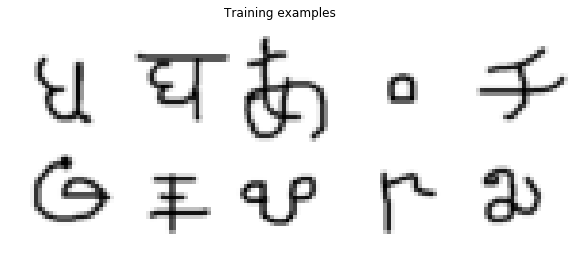

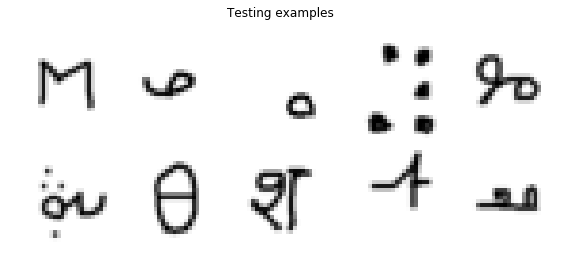

In [10]:
## show some examples (resize to 28x28)
images = []
for i in range(10):
    image_list = np.sort(glob.glob(os.path.join(list_all[keys_train[i]][0], '*.png')))
    ### note: both get_image() and transform() are from utils.py
    images.append(transform(get_image(image_list[0]), 105, 105, resize_height=x_dim, resize_width=x_dim, crop=False))
fig = plot(images, 2, 5)
fig.suptitle('Training examples')
fig.show()

images = []
for i in range(10):
    image_list = np.sort(glob.glob(os.path.join(list_all[keys_test[i]][0], '*.png')))
    ### note: both get_image() and transform() are from utils.py
    images.append(transform(get_image(image_list[0]), 105, 105, resize_height=x_dim, resize_width=x_dim, crop=False))
fig = plot(images, 2, 5)
fig.suptitle('Testing examples')
fig.show()

In [11]:
## use data format 2, with two lists (training and testing)
list_train = list_all[keys_train]
list_test = list_all[keys_test]
print(list_train)
print(list_train[:,1])
print(list_train.shape[0])

[['/data/put_data/cclin/datasets/omniglot/python/images_all/Gujarati/character33'
  '675']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Sanskrit/character04'
  '1345']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Japanese_(hiragana)/character01'
  '774']
 ...
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Braille/character08'
  '371']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Tifinagh/character34'
  '1575']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Oriya/character29'
  '1324']]
['675' '1345' '774' ... '371' '1575' '1324']
1200


## (2) Training

In [12]:
num_epoch = 1e4
Batch_Size = 32
learning_rate = 4e-5

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    net = MATCH_NET(sess,
                    model_name=dir_name)
    net.build_model()
    results = net.train(list_train=list_train,
                        list_test=list_test,
                        nEpochs=num_epoch,
                        bsize=Batch_Size,
                        learning_rate_start=learning_rate)

epoch: 100 | train_loss: 1.2196167 | train_acc: 0.46875 | test_loss: 1.0622087 | test_acc: 0.625
epoch: 200 | train_loss: 0.9755944 | train_acc: 0.71875 | test_loss: 1.0474561 | test_acc: 0.59375
epoch: 300 | train_loss: 0.91994464 | train_acc: 0.59375 | test_loss: 1.0681162 | test_acc: 0.59375
epoch: 400 | train_loss: 1.068712 | train_acc: 0.625 | test_loss: 0.8785274 | test_acc: 0.71875
epoch: 500 | train_loss: 0.8281989 | train_acc: 0.65625 | test_loss: 0.9062449 | test_acc: 0.75
epoch: 600 | train_loss: 0.90214205 | train_acc: 0.59375 | test_loss: 0.8386211 | test_acc: 0.71875
epoch: 700 | train_loss: 0.6968092 | train_acc: 0.71875 | test_loss: 1.175207 | test_acc: 0.59375
epoch: 800 | train_loss: 0.8095088 | train_acc: 0.75 | test_loss: 0.819168 | test_acc: 0.625
epoch: 900 | train_loss: 0.875419 | train_acc: 0.5625 | test_loss: 0.7012607 | test_acc: 0.8125
epoch: 1000 | train_loss: 0.83525896 | train_acc: 0.625 | test_loss: 0.7746078 | test_acc: 0.75
epoch: 1100 | train_loss: 0.6

epoch: 8400 | train_loss: 0.4299169 | train_acc: 0.78125 | test_loss: 0.2165308 | test_acc: 0.9375
epoch: 8500 | train_loss: 0.29861492 | train_acc: 0.9375 | test_loss: 0.28848785 | test_acc: 0.90625
epoch: 8600 | train_loss: 0.18976107 | train_acc: 0.96875 | test_loss: 0.3356085 | test_acc: 0.9375
epoch: 8700 | train_loss: 0.39913428 | train_acc: 0.90625 | test_loss: 0.2752135 | test_acc: 0.9375
epoch: 8800 | train_loss: 0.3971042 | train_acc: 0.875 | test_loss: 0.4209565 | test_acc: 0.9375
epoch: 8900 | train_loss: 0.33784658 | train_acc: 0.90625 | test_loss: 0.49882492 | test_acc: 0.84375
epoch: 9000 | train_loss: 0.1900986 | train_acc: 0.9375 | test_loss: 0.38391984 | test_acc: 0.875
epoch: 9100 | train_loss: 0.34402624 | train_acc: 0.90625 | test_loss: 0.38498133 | test_acc: 0.78125
epoch: 9200 | train_loss: 0.38433737 | train_acc: 0.875 | test_loss: 0.29944968 | test_acc: 0.90625
epoch: 9300 | train_loss: 0.40956187 | train_acc: 0.84375 | test_loss: 0.3602237 | test_acc: 0.875
ep